In [1]:
import tensorflow as tf
from flows import NormalRW, DFlow, ResFlow, NVPFlow, phase, Normal, floatX, MVNormal, MVNormalRW, Linear, CFlow, LinearChol
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.contrib.distributions import WishartCholesky

np.random.seed(1234)

In [2]:
data = pd.read_csv('./data/test_rus_data.csv').values.astype(floatX).T[np.newaxis][:,2:]/100

In [3]:
stds = (data[0,1:] - data[0,:-1]).std(axis=0)
print(stds)
data /= stds

[0.21742282 0.16835931 0.01139835]


In [4]:
xs = data

In [5]:
n = data.shape[1]
s1 = 0.01
s0 = 2.
dim = [3,4]

k = dim[0] * dim[1]
with tf.variable_scope('pwalk_inf', reuse=tf.AUTO_REUSE):
    lowerd = DFlow([NVPFlow(dim=k*(k-1)//2 + k, name='lowerd_flow_' + str(i)) for i in range(4)])
    ldiag = DFlow([NVPFlow(dim=k, name='ldiag_flow_' + str(i)) for i in range(4)])
PWalk = MVNormalRW(dim[0]*dim[1], sigma=s1, sigma0=s0, name='param_walk_prior', 
                   lowerd=lowerd.output[0], ldiag=ldiag.output[0]+np.log(1/s1))
# PWalk = MVNormalRW(dim[0]*dim[1], sigma=s1, sigma0=s0, name='param_walk_prior')

In [6]:
def autoregr_tf(X, param):
    d = param[:,:dim[-1]-1]
    X = tf.matmul(X, d) + param[:,-1][np.newaxis]
    return X

In [7]:
def create_step_flow(name=None, prev_flow_output=None, init_sigma=1.):
    with tf.variable_scope(name, reuse=False):
        
        if prev_flow_output is not None:
            aux_vars = prev_flow_output
        else:
            aux_vars = None
            
        step_flow = DFlow([NVPFlow(dim=dim[0]*dim[1], name='res{}'.format(i), aux_vars=aux_vars)\
                           for i in range(6)], 
                          init_sigma=init_sigma)
    return step_flow

In [8]:
flows = [create_step_flow('step_flow0', init_sigma=s0)]
outputs = [flows[-1].output]
for i in range(n-1):
    if i >= 1:
        aux = tf.concat([outputs[-1], outputs[-2]], 1)
    else:
        aux = outputs[-1]
    new = create_step_flow('step_flow' + str(i+1), aux, init_sigma=s1)
    flows.append(new)
    outputs.append(outputs[-1] + new.output)

In [9]:
outputs = tf.concat(outputs, axis=0)[tf.newaxis]

In [10]:
outputs

<tf.Tensor 'strided_slice_2:0' shape=(1, 20, 12) dtype=float64>

In [11]:
prior = PWalk.logdens(outputs)

In [12]:
prior

<tf.Tensor 'param_walk_prior_2/logdens/add:0' shape=() dtype=float64>

In [13]:
def create_loglik2():
    obs_d = Normal(dim=None, sigma=1., mu=0)
    out = tf.reshape(outputs, [n, dim[0], dim[1]])
    
    def step1(current):
        X = current[0][np.newaxis]
        param = current[1]
        d = param[:,:dim[-1]-1]
        X = tf.matmul(X, d)[0] + param[:,-1]
        return X
    
    ar = tf.map_fn(step1, (xs[0][:-1], out[:-1]), dtype=tf.float64)
    return obs_d.logdens(ar - xs[0][1:])

In [14]:
logl = create_loglik2()

In [15]:
ent = tf.reduce_sum([flow.logdens for flow in flows])

In [16]:
ent

<tf.Tensor 'Sum_1:0' shape=() dtype=float64>

In [17]:
df = dim[0]*dim[1]
pmat = np.diag([(1/s1**2)]*(dim[0]*dim[1]))/df
cov_prior = WishartCholesky(df, pmat, cholesky_input_output_matrices=True)

In [18]:
loss = -logl - prior + ent - cov_prior.log_prob(PWalk.fsigma) + lowerd.logdens + ldiag.logdens
loss /= n*dim[0]*dim[1]

In [19]:
tf.summary.scalar('loss', loss[0])

<tf.Tensor 'loss:0' shape=() dtype=string>

In [20]:
opt = tf.train.AdamOptimizer(0.0001).minimize(loss)

In [21]:
sess = tf.InteractiveSession()

In [22]:
tf.global_variables_initializer().run()

In [23]:
prior.eval(), ent.eval(), logl.eval()

(-2308.6196926459156, 703.5874676466697, -4760.767731057554)

In [24]:
loss.eval()

array([87.7417563])

In [25]:
np.set_printoptions(precision=4)

In [26]:
PWalk.inverse_sigma.eval()[:3,:3]

array([[ 1.1542e+04,  5.4938e+01,  9.2408e+01],
       [ 5.4938e+01,  1.3776e+04, -5.4678e+01],
       [ 9.2408e+01, -5.4678e+01,  5.7702e+04]])

In [27]:
!rm -R /tmp/tfdbg
all_sum = tf.summary.merge_all()
writer = tf.summary.FileWriter('/tmp/tfdbg')

In [ ]:
%%time
for _ in range(50000):
    for _ in range(400):
        l, _ = sess.run([loss, opt], {phase:True})
    print(l)
    print(PWalk.inverse_sigma.eval()[:3,:3])
    print('\n')
    writer.add_summary(all_sum.eval())

[45.2688]
[[ 2072.2564   -36.1224   -57.1198]
 [  -36.1224  1823.3276   -41.5702]
 [  -57.1198   -41.5702 30128.5874]]


[42.8499]
[[ 7862.7451 -1177.6887 -1142.3895]
 [-1177.6887  1175.9755    49.3933]
 [-1142.3895    49.3933  2623.4869]]


[8.0912]
[[36523.859  -5780.1317  4458.1285]
 [-5780.1317 36387.7104  -890.9466]
 [ 4458.1285  -890.9466  2182.2519]]


[11.1016]
[[294208.5668  -2221.9366  14618.3624]
 [ -2221.9366   3798.3582  -2074.9263]
 [ 14618.3624  -2074.9263  37614.9801]]


[7.6229]
[[16755.9891 -2716.4822  2481.4814]
 [-2716.4822 57270.3988 -1130.4346]
 [ 2481.4814 -1130.4346   643.8182]]


[7.531]
[[410409.2529  21375.9943   3639.7714]
 [ 21375.9943   6990.1969  -2239.3518]
 [  3639.7714  -2239.3518   1518.9226]]


[7.5235]
[[  9381.6063  -3657.6507   3093.7572]
 [ -3657.6507   5249.8081    637.4022]
 [  3093.7572    637.4022 295998.0736]]


[6.0608]
[[18110.5592 -1371.3285   149.0645]
 [-1371.3285  1021.9076   404.2397]
 [  149.0645   404.2397   476.9686]]


[6.1359]
[[

In [77]:
# saver = tf.train.Saver()

In [78]:
# saver.save(sess,'/home/nikita/tmp/rdata')

In [52]:
ss = []
for _ in range(3000):
    a = np.linalg.inv(PWalk.inverse_sigma.eval())
    ss.append(np.sqrt(np.diag(a)))
ss = np.array(ss)

In [53]:
np.mean(ss, axis=0), np.std(ss, axis=0)

(array([0.2672, 0.0492, 0.0035, 0.0019, 0.0014, 0.0011, 0.001 , 0.0009,
        0.0008, 0.0007, 0.0007, 0.0006]),
 array([5.9381e-02, 1.1096e-02, 7.5316e-04, 4.2027e-04, 2.8650e-04,
        2.1709e-04, 1.8536e-04, 1.6611e-04, 1.4010e-04, 1.2849e-04,
        1.1541e-04, 9.8524e-05]))

In [31]:
np.mean(ss, axis=0), np.std(ss, axis=0)

(array([0.2649, 0.0483, 0.0036, 0.0019, 0.0015, 0.0012, 0.001 , 0.0009,
        0.0008, 0.0007, 0.0007, 0.0006]),
 array([0.0606, 0.0105, 0.0008, 0.0004, 0.0003, 0.0002, 0.0002, 0.0002,
        0.0001, 0.0001, 0.0001, 0.0001]))

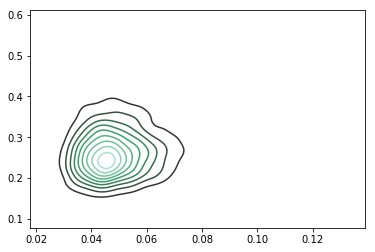

In [54]:
sns.kdeplot(ss[:,1], ss[:,0])
plt.show()

In [33]:
out = tf.reshape(outputs, [n, dim[0], dim[1]])

In [55]:
samples = []
for _ in range(3000):
    s = out.eval()
    samples.append(s)
samples = np.array(samples)

In [56]:
samples.shape

(3000, 20, 3, 4)

In [59]:
samples[:,1,0,3].mean()

-0.6622840459907381

In [71]:
ix = np.abs(samples[:,5,2,0] - samples[:,5,2,0].mean()) < 0.02

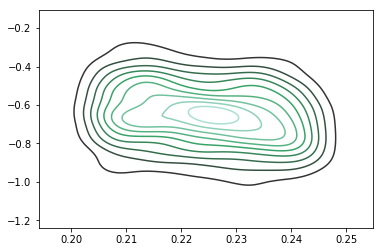

In [72]:
sns.kdeplot(samples[ix,5,2,0], samples[ix,11,0,3])
plt.show()

In [58]:
samples[:,10,2,0].mean()

0.22549790161060815

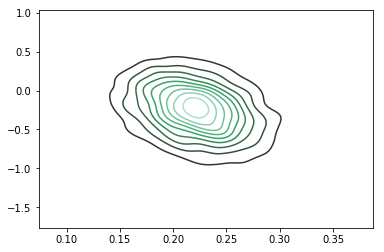

In [38]:
sns.kdeplot(samples[:,5,2,0], samples[:,5,0,0])
plt.show()

In [39]:
t = 10
# params[t]

In [40]:
np.mean(samples[:,t], axis=0)

array([[-0.3173, -0.0059, -0.1162, -0.6569],
       [ 0.0574,  0.1714,  0.5882,  0.0956],
       [ 0.221 , -0.018 ,  0.8688,  0.6791]])

In [41]:
np.std(samples[:,t], axis=0)

array([[0.4547, 0.1153, 0.0787, 0.1863],
       [0.0513, 0.0717, 0.1102, 0.0726],
       [0.036 , 0.0121, 0.0416, 0.2064]])

In [42]:
from scipy.stats import normaltest

In [50]:
normaltest(samples[:,13,2,3])

NormaltestResult(statistic=2.1575184713748143, pvalue=0.3400171451650124)

In [278]:
from sklearn.neighbors.kde import KernelDensity
def score(s1, s2):
    bw = 0.1
    s1 = s1[:,np.newaxis]
    s2 = s2[:,np.newaxis]
    e1 = KernelDensity(bandwidth=bw).fit(s1)
    e2 = KernelDensity(bandwidth=bw).fit(s2)
    
    e1e2 = e1.score(s1) - e2.score(s1)
    e2e1 = e2.score(s2) - e1.score(s2)
    dist = (e1e2/len(s1) + e2e1/len(s2))/2
    return dist

In [271]:
def get_cdf(ts):
    return lambda x: (ts <= x).mean()
def score(s1,s2):
    c1 = get_cdf(s1)
    c2 = get_cdf(s2)

    m = 0
    for s in np.concatenate([s1, s2]):
        r = np.abs(c1(s) - c2(s))
        if r > m:
            m = r
    return m

In [203]:
score(s1,s2)

0.00014521624382734903

In [279]:
dists = []
for t1 in range(samples.shape[1] - 1):
    np.random.seed(1234)
    print(t1)
    t2 = t1 + 1
    s1 = samples[:,t1,0,0]
    s2 = samples[:,t2,0,0]
    ss = []
    for _ in range(10):
        s1_ = np.random.choice(s1, size=8000)
        s2_ = np.random.choice(s2, size=8000)
        m = score(s1_,s2_)
        ss.append(m)
    dists.append(ss)
dists = np.array(dists).T

0
1
2
3
4
6
7
8
9
10
11
12
13
14
15
16
17
18


## KDE + KL

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


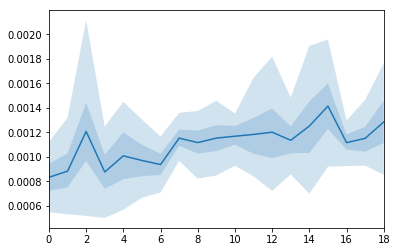

In [270]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


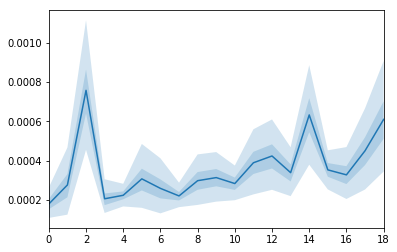

In [280]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

## Kolmogorov-Smirnov

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


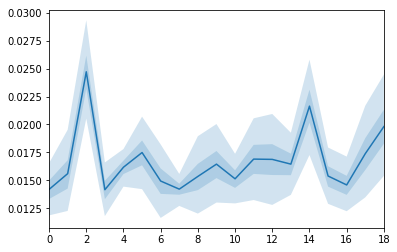

In [277]:
sns.tsplot(dists, ci=[50, 95])
plt.show()